In [1]:
import math
import numpy as np
import sklearn
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import re
import seaborn as sns
import pandas as pd
import random
from scipy import stats  #t-test
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

import xlrd
import statsmodels.api as sm
from itertools import groupby

from statistics import mean
from matplotlib import cm

from pyts.datasets import load_gunpoint
from pyts.image import RecurrencePlot

C:\Users\ljr\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def distance_matrixcrp(data1, data2, dimension, delay1, delay2, norm):
    N1 = int(len(data1) - (dimension-1) * delay1)
    N2 = int(len(data2) - (dimension-1) * delay2)
    distance_matrix = np.zeros((N1, N2), dtype="float32")
    if norm == 'manhattan':
        for i in range(N1):
            for j in range(N2):
                temp = 0.0
                for k in range(dimension):
                    temp += np.abs(data1[i+k*delay1] - data2[j+k*delay2])
                distance_matrix[i,j] = temp
    elif norm == 'euclidean':
        for i in range(N1):
            for j in range(N2):
                temp = 0.0
                for k in range(dimension):
                    temp += np.power(data1[i+k*delay1] - data2[j+k*delay2], 2)
                distance_matrix[i,j] = np.sqrt(temp)
    elif norm == 'supremum':
        temp = np.zeros(dimension)
        distance_matrix = np.zeros((N1, N2), dtype="float32")
        for i in range(N1):
            for j in range(N2):        
                for k in range(dimension):
                    temp[k] = np.abs(data1[i+k*delay1] - data2[j+k*delay2])
                distance_matrix[i,j] = np.max(temp)   
    return distance_matrix

def cross_matrixcrp(data1, data2, dimension, delay1, delay2, threshold, norm):
    cross_matrix = distance_matrixcrp(data1, data2, dimension, delay1, delay2, norm)
    N1 = len(cross_matrix[:,0])
    N2 = len(cross_matrix[0])
    for i in range(N1):
        for j in range(N2):
            if cross_matrix[i,j] <= threshold:
                cross_matrix[i,j] = 1
            else:
                cross_matrix[i,j] = 0
    return cross_matrix.astype(int)

def distance_matrixrp(data, dimension, delay, norm):
    N = int(len(data) - (dimension-1) * delay)
    distance_matrix = np.zeros((N, N), dtype="float32")
    if norm == 'manhattan':
        for i in range(N):
            for j in range(i, N, 1):
                temp = 0.0
                for k in range(dimension):
                    temp += np.abs(data[i+k*delay] - data[j+k*delay])
                distance_matrix[i,j] = distance_matrix[j,i] = temp
    elif norm == 'euclidean':
        for i in range(N):
            for j in range(i, N, 1):
                temp = 0.0
                for k in range(dimension):
                    temp += np.power(data[i+k*delay] - data[j+k*delay], 2)
                distance_matrix[i,j] = distance_matrix[j,i] = np.sqrt(temp)
    elif norm == 'supremum':
        temp = np.zeros(dimension)
        for i in range(N):
            for j in range(i, N, 1):
                for k in range(dimension):
                    temp[k] = np.abs(data[i+k*delay] - data[j+k*delay])
                distance_matrix[i,j] = distance_matrix[j,i] = np.max(temp)
    return distance_matrix

def recurrence_matrixrp(data, dimension, delay, threshold, norm):
    recurrence_matrix = distance_matrixrp(data, dimension, delay, norm)
    N = len(recurrence_matrix[:,0])
    for i in range(N):
        for j in range(i, N, 1):
            if recurrence_matrix[i,j] <= threshold:
                recurrence_matrix[i,j] = recurrence_matrix[j,i] = 1
            else:
                recurrence_matrix[i,j] = recurrence_matrix[j,i] = 0
    return recurrence_matrix.astype(int)



In [5]:
def distance_matrixjrp(data, dimension, delay, norm):
    N = int(len(data) - (dimension-1) * delay)
    distance_matrix = np.zeros((N, N), dtype="float32")
    if norm == 'manhattan':     
        for i in range(N):
            for j in range(i, N, 1):
                temp = 0.0
                for k in range(dimension):
                    temp += np.abs(data[i+k*delay] - data[j+k*delay])
                distance_matrix[i,j] = distance_matrix[j,i] = temp
    elif norm == 'euclidean':
        for i in range(N):
            for j in range(i, N, 1):
                temp = 0.0
                for k in range(dimension):
                    temp += np.power(data[i+k*delay] - data[j+k*delay], 2)
                distance_matrix[i,j] = distance_matrix[j,i] = np.sqrt(temp)
    elif norm == 'supremum':
        temp = np.zeros(dimension)
        for i in range(N):
            for j in range(i, N, 1):
                for k in range(dimension):
                    temp[k] = np.abs(data[i+k*delay] - data[j+k*delay])
                distance_matrix[i,j] = distance_matrix[j,i] = np.max(temp)
    return distance_matrix

def recurrence_matrixjrp(data, dimension, delay, threshold, norm):
    N = int(len(data) - (dimension-1) * delay)
    distance_matrix_1 = distance_matrixjrp(data, dimension, delay, norm)
    for i in range(N):
        for j in range(i, N, 1):
            if distance_matrix_1[i,j] <= threshold:
                distance_matrix_1[i,j] = distance_matrix_1[j,i] = 1
            else:
                distance_matrix_1[i,j] = distance_matrix_1[j,i] = 0
    return distance_matrix_1.astype(int)

def joint_matrixjrp(data1, data2, dimension1, dimension2, delay1, delay2, threshold1, threshold2, norm1, norm2):
    N1 = int(len(data1) - (dimension1-1) * delay1)
    N2 = int(len(data2) - (dimension2-1) * delay2)
    assert N1 == N2, "Space phase must have the same size"
    recurrence_matrix_1 = recurrence_matrixjrp(data1, dimension1, delay1, threshold1, norm1)
    recurrence_matrix_2 = recurrence_matrixjrp(data2, dimension2, delay2, threshold2, norm2)
    for i in range(N1):
        for j in range(i, N1, 1):
            if recurrence_matrix_1[i,j] == 1 and recurrence_matrix_2[i,j] == 1:
                recurrence_matrix_1[i,j] = recurrence_matrix_1[j,i] = 1
            else:
                recurrence_matrix_1[i,j] = recurrence_matrix_1[j,i] = 0
    return recurrence_matrix_1.astype(int)

<Figure size 432x288 with 0 Axes>

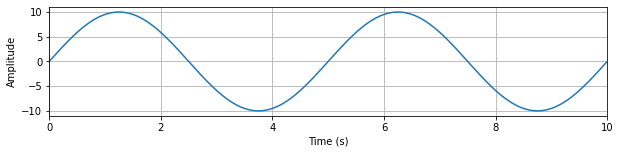

In [3]:
def create_sine_signal(freq, amplitude, duration, sample_rate):
    # Calculate the time axis
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    
    # Calculate the sine signal
    signal = amplitude * np.sin(2 * np.pi * freq * t)
    
    return t, signal

# Parameters for the sine signal
frequency = 0.2  # Frequency in Hz
amplitude = 10   # Amplitude of the sine wave
duration = 10  # Duration of the signal in seconds
sample_rate = 100 # Number of samples per second

# Create the sine signal
time_axis, sine_signal = create_sine_signal(frequency, amplitude, duration, sample_rate)

# Plot the sine signal
plt.figure()
plt.figure(figsize=(10,2))
plt.plot(time_axis, sine_signal)
plt.xlim(0,10)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Sine Signal')
plt.grid(True)
plt.show()

<Figure size 432x288 with 0 Axes>

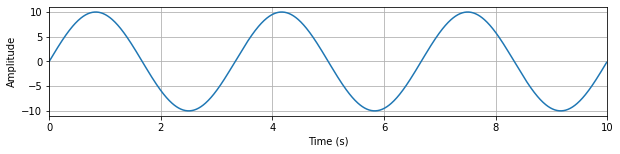

In [4]:
def create_sine_signal(freq, amplitude, duration, sample_rate):
    # Calculate the time axis
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    
    # Calculate the sine signal
    signal = amplitude * np.sin(2 * np.pi * freq * t)
    
    return t, signal

# Parameters for the sine signal
frequency = 0.3  # Frequency in Hz
amplitude = 10   # Amplitude of the sine wave
duration = 10  # Duration of the signal in seconds
sample_rate = 100 # Number of samples per second

# Create the sine signal
time_axis, sine_signal3 = create_sine_signal(frequency, amplitude, duration, sample_rate)

# Plot the sine signal
plt.figure()
plt.figure(figsize=(10,2))
plt.plot(time_axis, sine_signal3)
plt.xlim(0,10)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Sine Signal')
plt.grid(True)
plt.show()

In [6]:
noise = np.random.normal(0,8,len(sine_signal))
sinaddnoise=sine_signal+noise

<Figure size 432x288 with 0 Axes>

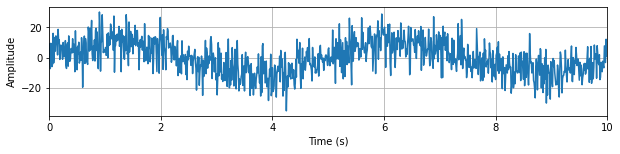

In [7]:
plt.figure()
plt.figure(figsize=(10,2))
plt.plot(time_axis, sinaddnoise)
plt.xlim(0,10)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Sine Signal')
plt.grid(True)
plt.show()

In [8]:
def create_cos_signal(freq, amplitude, duration, sample_rate):
    # Calculate the time axis
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    
    # Calculate the sine signal
    signal = amplitude * np.cos(2 * np.pi * freq * t)
    
    return t, signal

<Figure size 432x288 with 0 Axes>

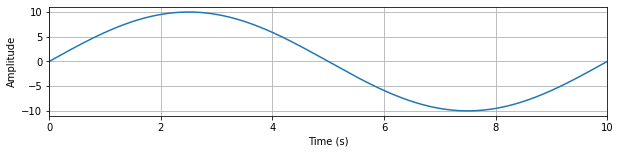

In [9]:
# Parameters for the sine signal
frequency = 0.1  # Frequency in Hz
amplitude = 10   # Amplitude of the sine wave
duration = 10  # Duration of the signal in seconds
sample_rate = 100 # Number of samples per second

# Create the sine signal
time_axis2, sine_signal2 = create_sine_signal(frequency, amplitude, duration, sample_rate)

# Plot the sine signal
plt.figure()
plt.figure(figsize=(10,2))
plt.plot(time_axis2, sine_signal2)
plt.xlim(0,10)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Sine Signal')
plt.grid(True)
plt.show()

In [10]:
timec=np.zeros(len(sine_signal)+len(sine_signal2))
signalc1=np.zeros(len(sine_signal)+len(sine_signal2))
signalc2=np.zeros(len(sine_signal)+len(sine_signal2))
timec[:len(sine_signal)]=time_axis
timec[len(sine_signal):]=time_axis2+10

signalc1[:len(sine_signal)]=sine_signal
signalc1[len(sine_signal):]=sine_signal3

signalc2[:len(sine_signal)]=sine_signal
signalc2[len(sine_signal):]=sine_signal2

<Figure size 432x288 with 0 Axes>

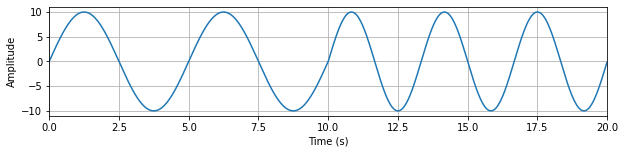

In [11]:
# Plot the sine signal
plt.figure()
plt.figure(figsize=(10,2))
plt.plot(timec,signalc1)
plt.xlim(0,20)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Sine Signal')
plt.grid(True)
plt.show()

<Figure size 432x288 with 0 Axes>

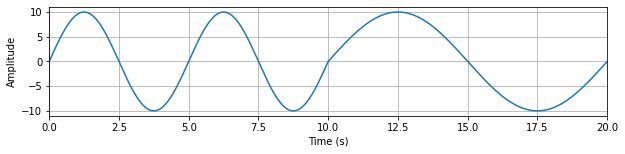

In [12]:
# Plot the sine signal
plt.figure()
plt.figure(figsize=(10,2))
plt.plot(timec,signalc2)
plt.xlim(0,20)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#plt.title('Sine Signal')
plt.grid(True)
plt.show()

In [13]:
data1, dimension1, delay1, threshold1, norm1 = sine_signal,1, 2, np.pi/2, "manhattan"
data2, dimension2, delay2, threshold2, norm2 = sine_signal2,1, 2, np.pi/2, "manhattan"
distance_matrix_1 = distance_matrixjrp(data1, dimension1, delay1, norm1)
distance_matrix_2 = distance_matrixjrp(data2, dimension2, delay2, norm2)
recurrence_matrix_1 = recurrence_matrixjrp(data1, dimension1, delay1, threshold1, norm1)
recurrence_matrix_2 = recurrence_matrixjrp(data2, dimension2, delay2, threshold2, norm2)
joint_matrix = joint_matrixjrp(data1, data2, dimension1, dimension2, delay1, delay2, threshold1, threshold2, norm1, norm2)
LIN = len(joint_matrix[:,0])
COL = len(joint_matrix[0])

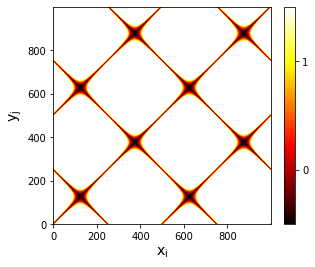

In [14]:
cmap = plt.get_cmap('binary', 2)
plt.imshow(distance_matrix_1, cmap = 'hot', vmin = 0, vmax = 1)
plt.axis([-0.5, COL-0.5, -0.5, LIN-0.5])
plt.xlabel(r'$\mathrm{x_{i}}$', fontsize=14)
plt.ylabel(r'$\mathrm{y_{j}}$', fontsize=14)
#plt.xticks([x for x in range(0, COL, 5)], [x+1 for x in range(0, COL, 5)])
#plt.yticks([x for x in range(0, LIN, 5)], [x+1 for x in range(0, LIN, 5)])
cbar = plt.colorbar(fraction=0.044, pad=0.04, ticks=[0.25,0.75])
cbar.ax.set_yticklabels(['0', '1'])
plt.show()

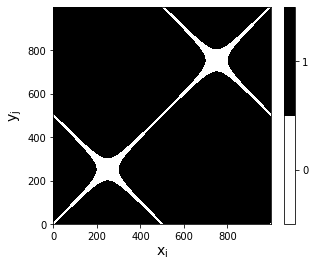

In [89]:
cmap = plt.get_cmap('binary', 2)
plt.imshow(distance_matrix_2, cmap = cmap, vmin = 0, vmax = 1)
plt.axis([-0.5, COL-0.5, -0.5, LIN-0.5])
plt.xlabel(r'$\mathrm{x_{i}}$', fontsize=14)
plt.ylabel(r'$\mathrm{y_{j}}$', fontsize=14)
#plt.xticks([x for x in range(0, COL, 5)], [x+1 for x in range(0, COL, 5)])
#plt.yticks([x for x in range(0, LIN, 5)], [x+1 for x in range(0, LIN, 5)])
cbar = plt.colorbar(fraction=0.044, pad=0.04, ticks=[0.25,0.75])
cbar.ax.set_yticklabels(['0', '1'])
plt.show()

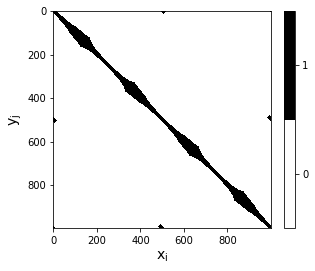

In [87]:
cmap = plt.get_cmap('binary', 2)
plt.imshow(joint_matrix, cmap = cmap, vmin = 0, vmax = 1)
plt.axis([-0.5, COL-0.5, -0.5, LIN-0.5])
plt.xlabel(r'$\mathrm{x_{i}}$', fontsize=14)
plt.ylabel(r'$\mathrm{y_{j}}$', fontsize=14)
#plt.xticks([x for x in range(0, COL, 5)], [x+1 for x in range(0, COL, 5)])
#plt.yticks([x for x in range(0, LIN, 5)], [x+1 for x in range(0, LIN, 5)])
cbar = plt.colorbar(fraction=0.044, pad=0.04, ticks=[0.25,0.75])
cbar.ax.set_yticklabels(['0', '1'])
plt.show()

In [92]:
distance_matrix = distance_matrixcrp(data1, data2, dimension1, delay1, delay2, norm1)
cross_matrix = cross_matrixcrp(data1, data2, dimension1, delay1, delay2, threshold1, norm1)
distance_matrix = np.transpose(distance_matrix)
cross_matrix = np.transpose(cross_matrix)
LIN = len(distance_matrix[:,0])
COL = len(distance_matrix[0])

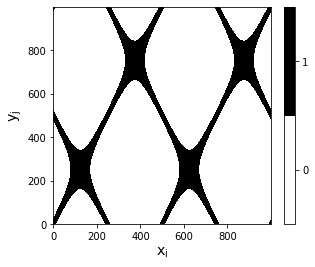

In [93]:
cmap = plt.get_cmap('binary', 2)
plt.imshow(cross_matrix, cmap = cmap, vmin = 0, vmax = 1)
plt.axis([-0.5, COL-0.5, -0.5, LIN-0.5])
plt.xlabel(r'$\mathrm{x_{i}}$', fontsize=14)
plt.ylabel(r'$\mathrm{y_{j}}$', fontsize=14)
#plt.xticks([x for x in range(0, COL, 5)], [x+1 for x in range(0, COL, 5)])
#plt.yticks([x for x in range(0, LIN, 5)], [x+1 for x in range(0, LIN, 5)])
cbar = plt.colorbar(fraction=0.044, pad=0.04, ticks=[0.25,0.75])
cbar.ax.set_yticklabels(['0', '1'])
plt.show()

In [94]:
def recurrence_quantification_analysis(recurrence_matrix, minimum_diagonal_line_length, minimum_vertical_line_length, minimum_white_vertical_line_length):
    # Calculating the number of states - N
    number_of_vectors = recurrence_matrix.shape[0]
    
    # Calculating the diagonal frequency distribution - P(l)
    diagonal_frequency_distribution = np.zeros(number_of_vectors+1)
    for i in range(number_of_vectors-1, -1, -1):
        diagonal_line_length = 0
        for j in range(0, number_of_vectors-i):
            if recurrence_matrix[i+j,j] == 1:
                diagonal_line_length += 1
                if j == (number_of_vectors-i-1):
                    diagonal_frequency_distribution[diagonal_line_length] += 1.0
            else:
                if diagonal_line_length != 0:
                    diagonal_frequency_distribution[diagonal_line_length] += 1.0
                    diagonal_line_length = 0
    for k in range(1,number_of_vectors):
        diagonal_line_length = 0
        for i in range(number_of_vectors-k):
            j = i + k
            if recurrence_matrix[i,j] == 1:
                diagonal_line_length += 1
                if j == (number_of_vectors-1):
                    diagonal_frequency_distribution[diagonal_line_length] += 1.0
            else:
                if diagonal_line_length != 0:
                    diagonal_frequency_distribution[diagonal_line_length] += 1.0
                    diagonal_line_length = 0

    # Calculating the vertical frequency distribution - P(v)
    vertical_frequency_distribution = np.zeros(number_of_vectors+1)
    for i in range(number_of_vectors):
        vertical_line_length = 0
        for j in range(number_of_vectors):
            if recurrence_matrix[i,j] == 1:
                vertical_line_length += 1
                if j == (number_of_vectors-1):
                    vertical_frequency_distribution[vertical_line_length] += 1.0
            else:
                if vertical_line_length != 0:
                    vertical_frequency_distribution[vertical_line_length] += 1.0
                    vertical_line_length = 0

    # Calculating the white vertical frequency distribution - P(w)
    white_vertical_frequency_distribution = np.zeros(number_of_vectors+1)
    for i in range(number_of_vectors):
        white_vertical_line_length = 0
        for j in range(number_of_vectors):
            if recurrence_matrix[i,j] == 0:
                white_vertical_line_length += 1
                if j == (number_of_vectors-1):
                    white_vertical_frequency_distribution[white_vertical_line_length] += 1.0
            else:
                if white_vertical_line_length != 0:
                    white_vertical_frequency_distribution[white_vertical_line_length] += 1.0
                    white_vertical_line_length = 0

    # Calculating the recurrence rate - RR
    recurrence_rate = np.float(np.sum(recurrence_matrix))/np.power(number_of_vectors, 2)

    # Calculating the determinism - DET
    numerator = np.sum([l * diagonal_frequency_distribution[l] for l in range(minimum_diagonal_line_length, number_of_vectors)])
    denominator = np.sum([l * diagonal_frequency_distribution[l] for l in range(1, number_of_vectors)])
    determinism = numerator / denominator

    # Calculating the average diagonal line length - L
    numerator = np.sum([l * diagonal_frequency_distribution[l] for l in range(minimum_diagonal_line_length, number_of_vectors)])
    denominator = np.sum([diagonal_frequency_distribution[l] for l in range(minimum_diagonal_line_length, number_of_vectors)])
    average_diagonal_line_length = numerator / denominator

    # Calculating the longest diagonal line length - Lmax
    for l in range(number_of_vectors-1, 0, -1):
        if diagonal_frequency_distribution[l] != 0:
            longest_diagonal_line_length = l
            break

    # Calculating the  divergence - DIV
    divergence = 1. / longest_diagonal_line_length

    # Calculating the entropy diagonal lines - Lentr
    sum_diagonal_frequency_distribution = np.float(np.sum(diagonal_frequency_distribution[minimum_diagonal_line_length:-1]))
    entropy_diagonal_lines = 0
    for l in range(minimum_diagonal_line_length, number_of_vectors):
        if diagonal_frequency_distribution[l] != 0:
            entropy_diagonal_lines +=  (diagonal_frequency_distribution[l]/sum_diagonal_frequency_distribution) * np.log(diagonal_frequency_distribution[l]/sum_diagonal_frequency_distribution)
    entropy_diagonal_lines *= -1

    # Calculating the ratio determinism_recurrence - DET/RR
    ratio_determinism_recurrence_rate = determinism / recurrence_rate

    # Calculating the laminarity - LAM
    numerator = np.sum([v * vertical_frequency_distribution[v] for v in range(minimum_vertical_line_length, number_of_vectors+1)])
    denominator = np.sum([v * vertical_frequency_distribution[v] for v in range(1, number_of_vectors+1)])
    laminarity = numerator / denominator

    # Calculating the average vertical line length - V
    numerator = np.sum([v * vertical_frequency_distribution[v] for v in range(minimum_vertical_line_length, number_of_vectors+1)])
    denominator = np.sum([vertical_frequency_distribution[v] for v in range(minimum_vertical_line_length, number_of_vectors+1)])
    average_vertical_line_length = numerator / denominator

    # Calculating the longest vertical line length - Vmax
    for v in range(number_of_vectors, 0, -1):
        if vertical_frequency_distribution[v] != 0:
            longest_vertical_line_length = v
            break

    # Calculating the entropy vertical lines - Ventr
    sum_vertical_frequency_distribution = np.float(np.sum(vertical_frequency_distribution[minimum_vertical_line_length:]))
    entropy_vertical_lines = 0
    for v in range(minimum_vertical_line_length, number_of_vectors+1):
        if vertical_frequency_distribution[v] != 0:
            entropy_vertical_lines +=  (vertical_frequency_distribution[v]/sum_vertical_frequency_distribution) * np.log(vertical_frequency_distribution[v]/sum_vertical_frequency_distribution)
    entropy_vertical_lines *= -1

    # Calculatint the ratio laminarity_determinism - LAM/DET
    ratio_laminarity_determinism = laminarity / determinism

    # Calculating the average white vertical line length - W
    numerator = np.sum([w * white_vertical_frequency_distribution[w] for w in range(minimum_white_vertical_line_length, number_of_vectors+1)])
    denominator = np.sum([white_vertical_frequency_distribution[w] for w in range(minimum_white_vertical_line_length, number_of_vectors+1)])
    average_white_vertical_line_length = numerator / denominator

    # Calculating the longest white vertical line length - Wmax
    for w in range(number_of_vectors, 0, -1):
        if white_vertical_frequency_distribution[w] != 0:
            longest_white_vertical_line_length = w
            break

    # Calculating the entropy white vertical lines - Wentr
    sum_white_vertical_frequency_distribution = np.float(np.sum(white_vertical_frequency_distribution[minimum_white_vertical_line_length:]))
    entropy_white_vertical_lines = 0
    for w in range(minimum_white_vertical_line_length, number_of_vectors+1):
        if white_vertical_frequency_distribution[w] != 0:
            entropy_white_vertical_lines +=  (white_vertical_frequency_distribution[w]/sum_white_vertical_frequency_distribution) * np.log(white_vertical_frequency_distribution[w]/sum_white_vertical_frequency_distribution)
    entropy_white_vertical_lines *= -1

    return diagonal_frequency_distribution, vertical_frequency_distribution, white_vertical_frequency_distribution, recurrence_rate, determinism, average_diagonal_line_length, longest_diagonal_line_length, divergence, entropy_diagonal_lines, laminarity, average_vertical_line_length, longest_vertical_line_length, entropy_vertical_lines, average_white_vertical_line_length, longest_white_vertical_line_length, entropy_white_vertical_lines, ratio_determinism_recurrence_rate, ratio_laminarity_determinism

In [97]:
minimum_diagonal_line_length, minimum_vertical_line_length, minimum_white_vertical_line_length=1,1,1
diagonal_frequency_distribution, vertical_frequency_distribution, white_vertical_frequency_distribution, recurrence_rate, determinism, average_diagonal_line_length, longest_diagonal_line_length, divergence, entropy_diagonal_lines, laminarity, average_vertical_line_length, longest_vertical_line_length, entropy_vertical_lines, average_white_vertical_line_length, longest_white_vertical_line_length, entropy_white_vertical_lines, ratio_determinism_recurrence_rate, ratio_laminarity_determinism=recurrence_quantification_analysis(cross_matrix, minimum_diagonal_line_length, minimum_vertical_line_length, minimum_white_vertical_line_length)

<ipython-input-94-dd66bbe25967>:60: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  recurrence_rate = np.float(np.sum(recurrence_matrix))/np.power(number_of_vectors, 2)
<ipython-input-94-dd66bbe25967>:82: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sum_diagonal_frequency_distribution = np.float(np.sum(diagonal_frequency_distribution[minim

In [98]:
print(diagonal_frequency_distribution, vertical_frequency_distribution, white_vertical_frequency_distribution, recurrence_rate, determinism, average_diagonal_line_length, longest_diagonal_line_length, divergence, entropy_diagonal_lines, laminarity, average_vertical_line_length, longest_vertical_line_length, entropy_vertical_lines, average_white_vertical_line_length, longest_white_vertical_line_length, entropy_white_vertical_lines, ratio_determinism_recurrence_rate, ratio_laminarity_determinism)

[ 0. 18. 18. ...  0.  0.  0.] [0. 8. 8. ... 0. 0. 0.] [0. 8. 8. ... 0. 0. 0.] 0.157236 1.0 44.17982579376229 153 0.006535947712418301 4.07888756190117 1.0 46.602252519264965 129 3.6386831510912723 202.10167865707433 409 5.55641405751893 6.359866697194027 1.0


In [55]:
rp = RecurrencePlot(dimension=1,time_delay=2,threshold=np.pi/2)
X_rp = rp.transform([sinaddnoise])

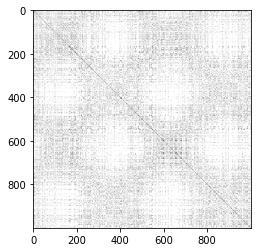

In [56]:
plt.imshow(X_rp[0],cmap='binary')

In [57]:
from pyts.datasets import load_basic_motions
X, _, _, _ = load_basic_motions(return_X_y=True)

In [63]:
from pyts.datasets import load_gunpoint

# Load the GunPoint dataset
X, _, _, _ = load_gunpoint(return_X_y=True)

In [11]:
datar1=[round(i,1) for i in sine_signal] # this step is to diacretize the input. If you define a tolerance, you don'need this step anymore
datar2=[round(i,1) for i in sine_signal2]
datar3=[round(i,1) for i in sinaddnoise]

datar4=[round(i,1) for i in signalc1]
datar5=[round(i,1) for i in signalc2]

In [59]:
def rrcoutblue(y,yi): # for the recurrence plot, please define y=yi
    ya=np.array(y)
    yia=np.array(yi)
    matrix=np.zeros((len(ya),len(yia))) #initialize the matrix for the horizontal axis
    matrixx=np.zeros((len(ya),len(yia))) #initialize the matrix for the vertical axis
    matrixc=np.zeros((len(ya),len(yia)))-100 # intitialize the color matrix to distinguish the values on the plots
    for i in range(len(ya)): # go through the y sequency, and find all the equalized value in yi for each time point in y sequence
        indf=np.where(yia==ya[i]) # if you want to define the tolerance,not y=yi, but |y-yi|<tolerance, please modify this line as indf=np.where(abs(yia-ya[i])<tolerance) 
        iii=indf[0]
        yyy=np.array([np.nan]*len(yia))
        yyyt=np.array([np.nan]*len(yia))
        xlabel=np.zeros((1,len(ya)))+i
        matrixx[:,i]=xlabel
        if len(iii)!=0:
            yyy[iii]=ya[i]
            yyyt[iii]=iii
            matrix[:,i]=yyyt
            matrixc[:,i]=yyy
    for j in range(len(matrixc[:,0])):
        inddd=np.where(matrixc[j,:]==-100)
        inddd0=np.array(inddd[0])
        matrixc[j,inddd0]=np.nan
    plt.figure(figsize=(10,10)) # plot the figure
    plt.axis('off')
    dx=np.arange(len(ya))
    cmap=cm.get_cmap('hsv',11)
    plt.scatter([i for i in matrixx],[j for j in matrix],s=1)
    plt.xlim(0,len(ya))
    plt.ylim(0,len(ya))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #cbar=plt.colorbar()
    #tick_font_size = 30
    #cbar.ax.tick_params(labelsize=tick_font_size)
    #cbar.locator=mpl.ticker.MaxNLocator(nbins=11)
    #cbar.update_ticks()
    plt.show()

<ipython-input-59-f2a5323cf3f8>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('hsv',11)


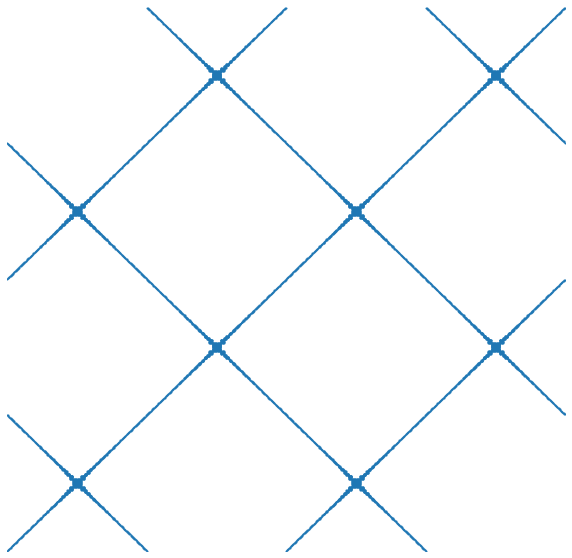

In [69]:
rrcoutblue(datar1,datar1)

<ipython-input-59-f2a5323cf3f8>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('hsv',11)


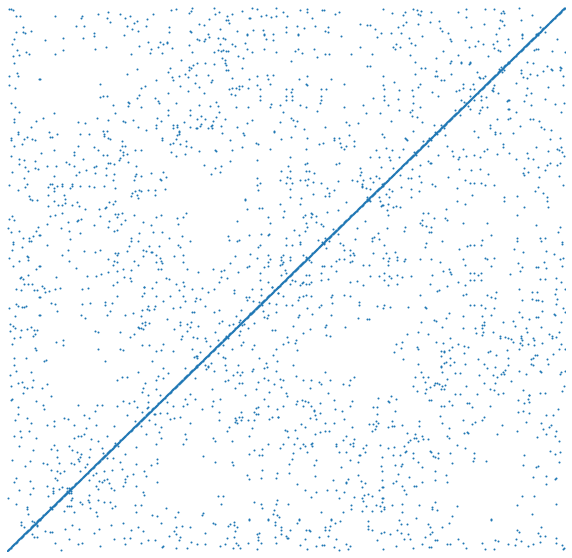

In [70]:
rrcoutblue(datar3,datar3)

<ipython-input-59-f2a5323cf3f8>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('hsv',11)


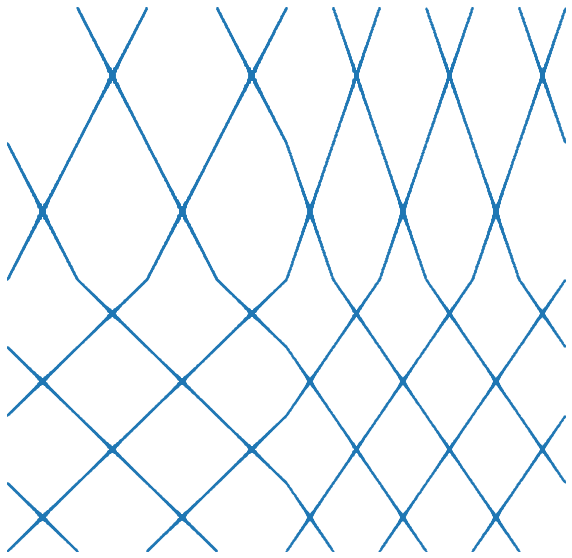

In [85]:
rrcoutblue(datar4,datar5)

<ipython-input-61-6dc3dcfe7f48>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('hsv',11)


Text(0.5, 0, 'Time (s)')

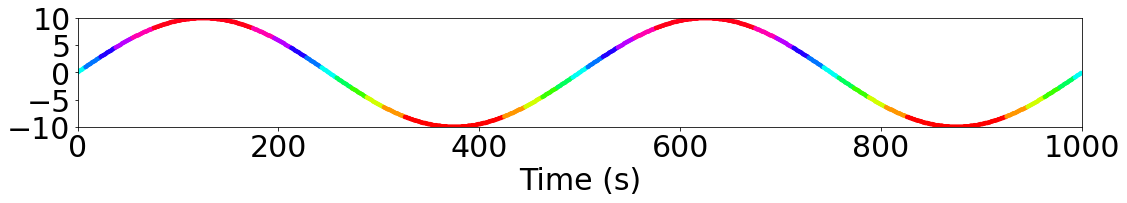

In [61]:
xlabel=np.arange(len(sine_signal)) # plot the input1
plt.figure(figsize=(18,2))
cmap=cm.get_cmap('hsv',11)
plt.scatter(xlabel,datar1,c=datar1,cmap=cmap,s=12,vmin=-10, vmax=10)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlim(0,len(sine_signal))
plt.ylim(-10,10)
plt.xlabel('Time (s)',fontsize=30)

In [62]:
def rrcout(y,yi): # for the recurrence plot, please define y=yi
    ya=np.array(y)
    yia=np.array(yi)
    matrix=np.zeros((len(ya),len(yia))) #initialize the matrix for the horizontal axis
    matrixx=np.zeros((len(ya),len(yia))) #initialize the matrix for the vertical axis
    matrixc=np.zeros((len(ya),len(yia)))-100 # intitialize the color matrix to distinguish the values on the plots
    for i in range(len(ya)): # go through the y sequency, and find all the equalized value in yi for each time point in y sequence
        indf=np.where(yia==ya[i]) # if you want to define the tolerance,not y=yi, but |y-yi|<tolerance, please modify this line as indf=np.where(abs(yia-ya[i])<tolerance) 
        iii=indf[0]
        yyy=np.array([np.nan]*len(yia))
        yyyt=np.array([np.nan]*len(yia))
        xlabel=np.zeros((1,len(ya)))+i
        matrixx[:,i]=xlabel
        if len(iii)!=0:
            yyy[iii]=ya[i]
            yyyt[iii]=iii
            matrix[:,i]=yyyt
            matrixc[:,i]=yyy
    for j in range(len(matrixc[:,0])):
        inddd=np.where(matrixc[j,:]==-100)
        inddd0=np.array(inddd[0])
        matrixc[j,inddd0]=np.nan
    plt.figure(figsize=(12,10)) # plot the figure
    plt.axis('off')
    dx=np.arange(len(ya))
    cmap=cm.get_cmap('hsv',11)
    plt.scatter([i for i in matrixx],[j for j in matrix],c=[k for k in matrixc],cmap=cmap,s=1,vmin=-10, vmax=10)
    plt.xlim(0,len(ya))
    plt.ylim(0,len(ya))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    cbar=plt.colorbar()
    tick_font_size = 30
    cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.locator=mpl.ticker.MaxNLocator(nbins=11)
    cbar.update_ticks()
    plt.show()

<ipython-input-62-3818c4e6c8ec>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('hsv',11)


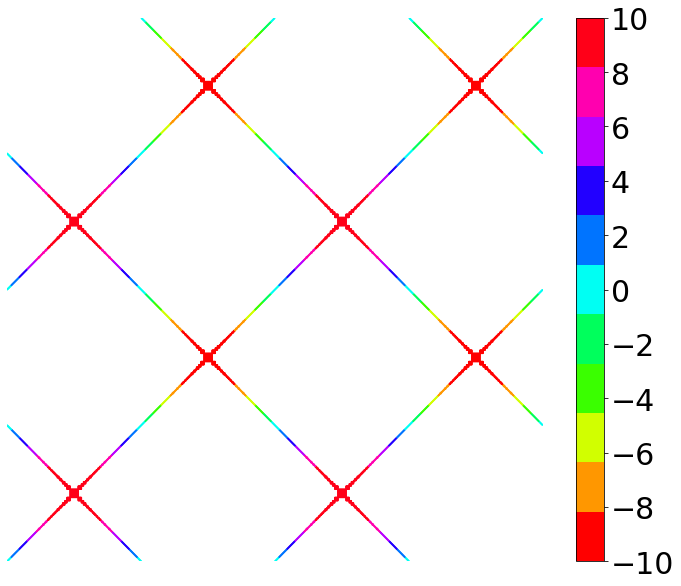

In [63]:
rrcout(datar1,datar1)

<ipython-input-62-3818c4e6c8ec>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=cm.get_cmap('hsv',11)


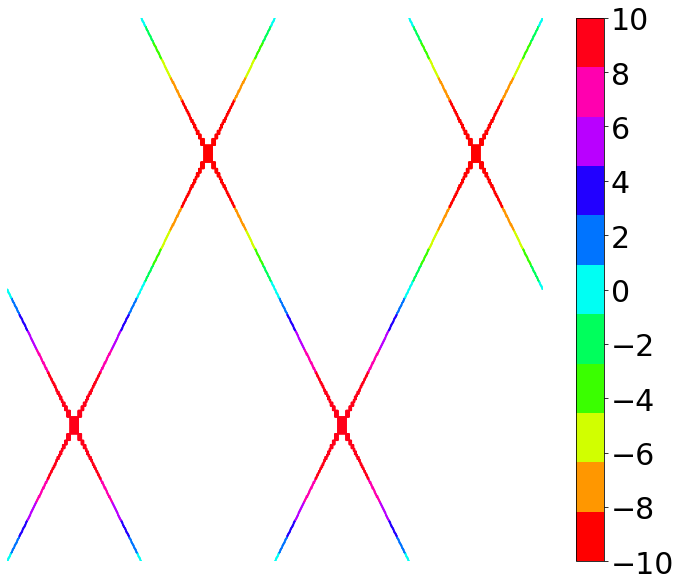

In [64]:
rrcout(datar1,datar2)